# Time Series Analysis

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

## a) Exploration

### i)

In [10]:
df = pd.read_csv("time-series/air_traffic.csv")

# 统一成“每月第一天”的时间戳，并按时间排序
df = pd.read_csv("time-series/air_traffic.csv")

df["date"] = pd.to_datetime(df[["Year", "Month"]].assign(DAY=1))
df = df.sort_values("date").set_index("date")
#类型转换
df["Flt"] = pd.to_numeric(df["Flt"].astype(str).str.replace(",", ""), errors="coerce")
df["Pax"] = pd.to_numeric(df["Pax"].astype(str).str.replace(",", ""), errors="coerce")

time_start = df.index.min()
time_end = df.index.max()

n_months = df.index.nunique()          # 追踪了多少个月（每行一个月的话等价于len(df)）
total_flights = df["Flt"].sum()      # overall flights

print("Time range:", time_start.date(), "to", time_end.date())
print("Months tracked:", n_months)
print("Overall flights:", total_flights)

Time range: 2003-01-01 to 2023-09-01
Months tracked: 249
Overall flights: 192100234


### ii)

In [11]:
import plotly.express as px

fig = px.line(
    df,
    y="Flt",
    title="Overall number of flights per month (Flt)",
    labels={"date": "Month", "Flt": "Flights"},
)
fig.show()

### iii)

In [14]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=df.index, y=df["Flt"], name="Flights (Flt)"), secondary_y=False)
fig.add_trace(go.Scatter(x=df.index, y=df["Pax"], name="Passengers (Pax)"), secondary_y=True)

fig.update_layout(title="Passengers vs Flights over time (two y-axes)")
fig.update_yaxes(title_text="Flights (Flt)", secondary_y=False)
fig.update_yaxes(title_text="Passengers (Pax)", secondary_y=True)
fig.show()


## b) Investigation
### i)

In [15]:
tmp = df.copy()
tmp["year"] = tmp.index.year
tmp["month"] = tmp.index.month

# Flights seasonal plot
fig1 = px.line(
    tmp, x="month", y="Flt", color="year",
    title="Yearly seasonal plot: Flights (Flt)",
    labels={"month": "Month", "Flt": "Flights", "year": "Year"}
)
fig1.show()

# Passengers seasonal plot
fig2 = px.line(
    tmp, x="month", y="Pax", color="year",
    title="Yearly seasonal plot: Passengers (Pax)",
    labels={"month": "Month", "Pax": "Passengers", "year": "Year"}
)
fig2.show()

### ii)

In [16]:
corr = df["Flt"].corr(df["Pax"])
corr


np.float64(0.5698387345242093)

### iii)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

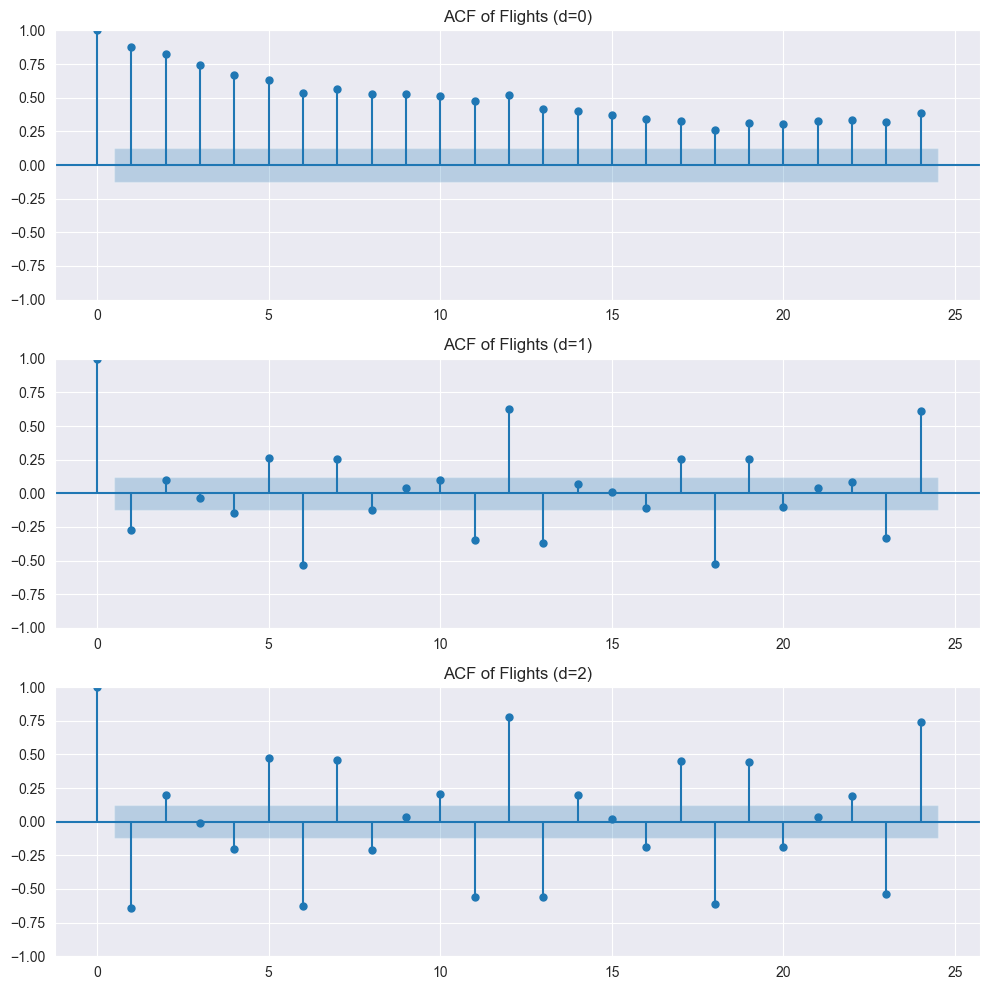

In [18]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

y0 = df["Flt"]
y1 = df["Flt"].diff().dropna()
y2 = df["Flt"].diff().diff().dropna()

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

plot_acf(y0, lags=24, bartlett_confint=False, ax=axs[0])
axs[0].set_title("ACF of Flights (d=0)")

plot_acf(y1, lags=24, bartlett_confint=False, ax=axs[1])
axs[1].set_title("ACF of Flights (d=1)")

plot_acf(y2, lags=24, bartlett_confint=False, ax=axs[2])
axs[2].set_title("ACF of Flights (d=2)")

plt.tight_layout()
plt.show()


### iv)

In [20]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

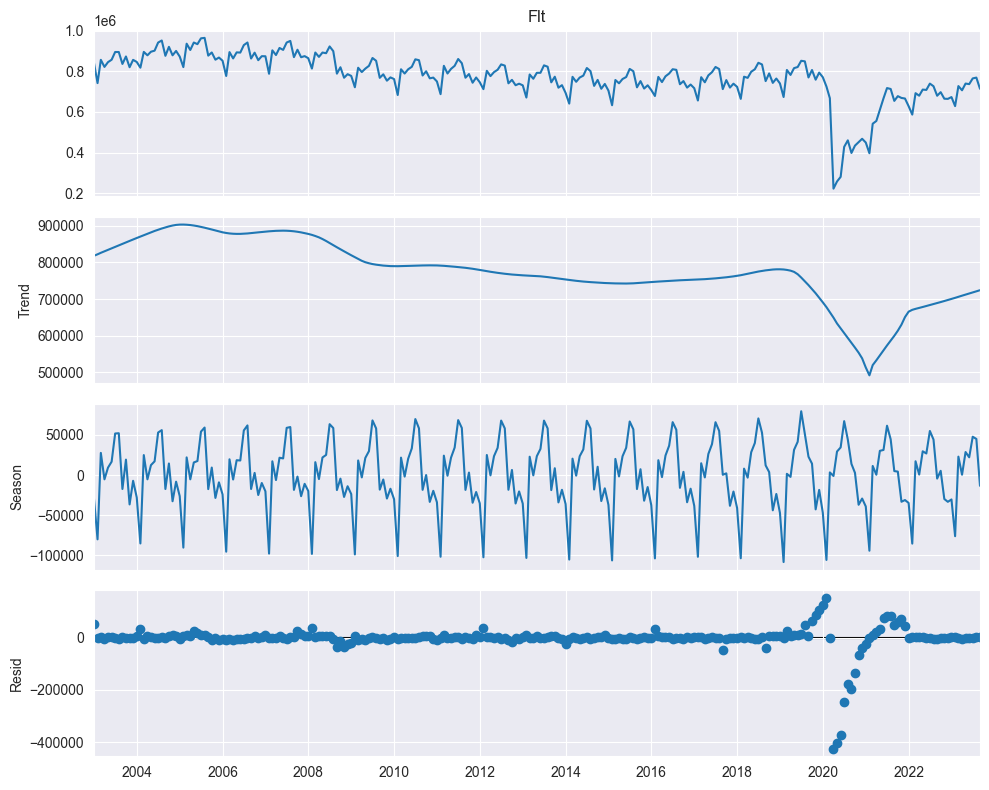

ADF statistic: -6.651776609766584
p-value: 5.099519810778243e-09


In [22]:
y = df["Flt"]

# STL 分解（period=12 个月）
stl = STL(y, period=12, robust=True)
res = stl.fit()

# 画 trend / seasonal / resid
fig = res.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

# 用 ADF 检验 residual 是否平稳
resid = res.resid.dropna()
adf_stat, p_value, _, _, _, _ = adfuller(resid)

print("ADF statistic:", adf_stat)
print("p-value:", p_value)



## c) Forecasting


### ii)

In [25]:
from sktime.forecasting.arima import StatsModelsARIMA
import numpy as np
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [32]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- load train/test (monthly PeriodIndex) ---
train = pd.read_csv("time-series/flights_train.csv")
test  = pd.read_csv("time-series/flights_test.csv")

train["date"] = pd.PeriodIndex(year=train["Year"], month=train["Month"], freq="M")
test["date"]  = pd.PeriodIndex(year=test["Year"],  month=test["Month"],  freq="M")

train = train.sort_values("date").set_index("date")
test  = test.sort_values("date").set_index("date")

train["Flt"] = pd.to_numeric(train["Flt"].astype(str).str.replace(",", ""), errors="coerce")
test["Flt"]  = pd.to_numeric(test["Flt"].astype(str).str.replace(",", ""), errors="coerce")

y_train = train["Flt"]
y_test  = test["Flt"]
fh = np.arange(1, len(y_test) + 1)

# --- Naive(mean) baseline ---
naive = NaiveForecaster(strategy="mean")
naive.fit(y_train)
pred_naive = naive.predict(fh)

rmse_n = mean_squared_error(y_test, pred_naive, square_root=True)
mae_n  = mean_absolute_error(y_test, pred_naive)
mape_n = mean_absolute_percentage_error(y_test, pred_naive)

print("Naive(mean)  RMSE, MAE, MAPE:", rmse_n, mae_n, mape_n)

# --- ARIMA(p,d,q) search in required ranges ---
best_order = None
best_metrics = None
best_pred = None

for p in range(1, 13):
    for d in range(0, 4):
        for q in range(1, 13):
            try:
                arima = StatsModelsARIMA(order=(p, d, q))
                arima.fit(y_train)
                pred = arima.predict(fh)

                rmse = mean_squared_error(y_test, pred, square_root=True)
                mae  = mean_absolute_error(y_test, pred)
                mape = mean_absolute_percentage_error(y_test, pred)

                # 题目要求：三项都要优于 naive
                if rmse < rmse_n and mae < mae_n and mape < mape_n:
                    if best_metrics is None or rmse < best_metrics[0]:
                        best_order = (p, d, q)
                        best_metrics = (rmse, mae, mape)
                        best_pred = pred
            except:
                pass

print("Best ARIMA order (p,d,q):", best_order)
print("ARIMA           RMSE, MAE, MAPE:", best_metrics)

C:\Users\22710\AppData\Local\Temp\ipykernel_26880\1755182934.py:10: FutureWarning:

Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.

C:\Users\22710\AppData\Local\Temp\ipykernel_26880\1755182934.py:11: FutureWarning:

Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.



Naive(mean)  RMSE, MAE, MAPE: 51192.09540780126 36663.857638888876 0.049011246090680395
Best ARIMA order (p,d,q): (12, 0, 9)
ARIMA           RMSE, MAE, MAPE: (np.float64(13627.400084195984), np.float64(10423.531177787236), np.float64(0.013455019260433196))



### iii)

In [33]:
# 重新生成两条预测（避免你没保存 best_pred）
pred_naive = naive.predict(fh)

arima_best = StatsModelsARIMA(order=(12, 0, 9))
arima_best.fit(y_train)
pred_arima = arima_best.predict(fh)

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_train.index.to_timestamp(), y=y_train, name="Train"))
fig.add_trace(go.Scatter(x=y_test.index.to_timestamp(),  y=y_test,  name="Test"))
fig.add_trace(go.Scatter(x=y_test.index.to_timestamp(),  y=pred_naive, name="Naive(mean) forecast"))
fig.add_trace(go.Scatter(x=y_test.index.to_timestamp(),  y=pred_arima, name="ARIMA(12,0,9) forecast"))

fig.update_layout(
    title="Flights forecasting: Train/Test with Naive(mean) and ARIMA(12,0,9)",
    xaxis_title="Month",
    yaxis_title="Flights (Flt)",
)
fig.show()